In [3]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import jaconv
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import geopandas as gpd
import contextily as ctx

os.chdir("/Users/shizukainoue/Desktop/Research/QSM/Japan/Data")

def safe_process_japanese_text(value):
    if isinstance(value, str):
        value = jaconv.h2z(value)  # Convert half-width to full-width
    return value  # Return the processed value or the original value if it's not a string

# Define a function to replace small ヶ with big ヶ
def replace_small_ke_with_big_ke(text):
    if isinstance(text, str):
        return text.replace('ヶ', 'ケ')
    return text

# Merge population and wage data

In [4]:
# Load population and wage data from Excel files
population_df = pd.read_excel('population 1970 2010.xls')
wage_df = pd.read_excel('average wage 1975_2014.xls')

# Clean up column names by removing leading/trailing spaces
population_df.columns = population_df.columns.str.strip()
wage_df.columns = wage_df.columns.str.strip()

# Rename population columns for clarity
population_df.columns = ['Municipality_Info', 'Municipality_Code', 'Population_1970', 'Population_1975', 'Population_1980', 
                         'Population_1985', 'Population_1990', 'Population_1995', 'Population_2000', 'Population_2005', 
                         'Population_2010']

# Rename wage columns dynamically
wage_columns = ['Municipality_Name', 'Municipality_Code'] + [f'Wage_{year}' for year in range(1975, 2014)]
wage_df.columns = wage_columns

# Ensure municipality codes are of the same type (string) for merging
population_df['Municipality_Code'] = population_df['Municipality_Code'].astype(str)
wage_df['Municipality_Code'] = wage_df['Municipality_Code'].astype(str)

# Merge population and wage datasets on the municipality code
merged_df = pd.merge(population_df, wage_df, left_on='Municipality_Code', right_on='Municipality_Code', how='inner')

# Ensure the 'Municipality_Code' column is of string type for manipulation
merged_df['Municipality_Code'] = merged_df['Municipality_Code'].astype(str)

# Drop the last digit from the 'Municipality_Code' column (possibly to standardize codes)
merged_df['Municipality_Code'] = merged_df['Municipality_Code'].str[:-1]

# Convert 'Municipality_Code' back to integer type
merged_df['Municipality_Code'] = merged_df['Municipality_Code'].astype(int)

# Split 'Municipality_Info' into 'PREF' (prefecture) and 'CITY' columns
merged_df[['PREF', 'CITY']] = merged_df['Municipality_Info'].str.split(n=1, expand=True)

# Apply text processing to standardize city names
merged_df['CITY'] = merged_df['CITY'].apply(replace_small_ke_with_big_ke)


# Compute the distance between each cities using the 2014 city definitions

In [5]:
# List of specified municipalities (政令指定都市)
specified_municipalities = [
    "札幌市", "仙台市", "さいたま市", "千葉市", "横浜市", "川崎市", "相模原市", "新潟市",
    "静岡市", "浜松市", "名古屋市", "京都市", "大阪市", "堺市", "神戸市", "岡山市",
    "広島市", "北九州市", "福岡市", "熊本市"
]

# Corresponding codes for 政令指定都市
# These are used because 区 (ku) has its own city code, but we want to aggregate ku to city level
specified_codes = [
    "01100", "04201", "11100", "12201", "14100", "14130", "14209", "15201",
    "22201", "22202", "23100", "26100", "27100", "27201", "28100", "33201",
    "34100", "40100", "40130", "43201"
]

# Set up the base directory and file path
base_dir = 'jpn2014'
base_path = os.path.join(base_dir, 'jpn2014geo.shp')

# Read the shapefile
base_gdf = gpd.read_file(base_path, encoding='shift_jis')

# Replace 'CITY' with 'GUN' for specified municipalities
base_gdf.loc[base_gdf['GUN'].isin(specified_municipalities), 'CITY'] = base_gdf['GUN']

# Replace 'CITY' with 'GUN' for areas containing '区' (ku)
base_gdf.loc[base_gdf['GUN'].fillna('').str.contains('区'), 'CITY'] = base_gdf['GUN']

# Create a mapping of municipalities to their codes
municipality_to_code = dict(zip(specified_municipalities, specified_codes))

# Apply new codes to specified municipalities, leaving others unchanged
base_gdf['N03_007'] = base_gdf['CITY'].map(municipality_to_code).fillna(base_gdf['N03_007'])    

# Create a unique key for each area
base_gdf['dissolve_key'] = base_gdf['PREF'].astype(str) + "_" + base_gdf['GUN'].astype(str) + "_" + base_gdf['CITY'].astype(str) 

# Dissolve (merge) areas with the same dissolve_key
base_gdf = base_gdf.dissolve(by = "dissolve_key")

# Reset the index after dissolving
base_gdf.reset_index(inplace=True)

# Project the data to a suitable Coordinate Reference System (CRS) for Japan
base_gdf = base_gdf.to_crs(epsg=2451)  # EPSG:2451 is JGD2000 / Japan Plane Rectangular CS IX

# Fix any invalid geometries
base_gdf['geometry'] = base_gdf['geometry'].buffer(0)

# Calculate the centroid of each area
base_gdf['centroid'] = base_gdf.geometry.centroid

# Sort the GeoDataFrame by the area code
base_gdf = base_gdf.sort_values(by='N03_007', ascending=True)

# Remove any rows with missing area codes
base_gdf = base_gdf.dropna(subset=['N03_007'])

# Ensure the area code is a string type
base_gdf['N03_007'] = base_gdf['N03_007'].astype(str)

# Remove leading zeros from the area code
base_gdf['N03_007'] = base_gdf['N03_007'].str.lstrip('0')

# Convert the area code to integer type
base_gdf['N03_007'] = base_gdf['N03_007'].astype(int)

# Replace small ヶ with big ケ in city names
base_gdf['CITY'] = base_gdf['CITY'].apply(replace_small_ke_with_big_ke)

# Merge the processed GeoDataFrame with the previously created merged_df
final_gdf = merged_df.merge(base_gdf, on=['PREF', 'CITY'], how='left', indicator=True)

In [6]:
# Extract the centroids and their coordinates from the final_gdf
centroids = final_gdf['centroid']
city_names = final_gdf['dissolve_key'] 

# Initialize a dataframe to store the distances between cities
# The rows and columns are labeled with city names
distance_matrix = pd.DataFrame(index=city_names, columns=city_names)

# Calculate distances between all pairs of cities
for i, city1 in enumerate(centroids):
    for j, city2 in enumerate(centroids):
        if i != j:
            # Calculate the Euclidean distance between city1 and city2
            # The formula is sqrt((x1-x2)^2 + (y1-y2)^2)
            # Divide by 1000 to convert from meters to kilometers
            distance = ((city1.x - city2.x)**2 + (city1.y - city2.y)**2)**0.5 / 1000
            distance_matrix.iloc[i, j] = distance
        else:
            # Distance from a city to itself is zero
            distance_matrix.iloc[i, j] = 0

In [7]:
# I assume that the trade cost is e^(phi*distance) following Naggy 2022 

# Define the trade cost parameter phi
phi = 0.01

# Convert the DataFrame to a NumPy array and ensure all values are numeric
distance_matrix_array = distance_matrix.to_numpy().astype(float)

# Multiply all values in the distance matrix by phi
# This scales the distances by the trade cost parameter
distance_matrix_array *= phi

# Calculate the trade costs (T) using a numerically stable approach
# np.clip is used to avoid overflow in exp calculation
# The resulting T represents the trade costs between locations
T = np.exp(np.clip(distance_matrix_array, -700, 700))

# Invert the model

In [9]:
# The equlibrium conditions are taken from Allen and Arkolakis 2014

# Define the years we want to process
years = [1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010]

# Parameters for the model
sigma = 9  # Elasticity of substitution
N = len(final_gdf)  # Number of locations
tol = 1e-6  # Convergence tolerance
max_iter = 1000  # Maximum number of iterations
min_alpha = 0.01  # Minimum learning rate
initial_alpha = 0.1  # Initial learning rate

# Dictionary to store convergence statistics
convergence_stats = {year: {'iterations': 0, 'final_diff': 0.0} for year in years}

for year in years:
    print(f"\nProcessing year {year}")
    
    # Extract Population (L) and Wage (w) for the current year
    L = final_gdf[f'Population_{year}'].tolist()
    w = final_gdf[f'Wage_{year}'].tolist()

    # Check for missing or invalid values
    missing_L = np.sum(np.isnan(L))
    missing_w = np.sum(np.isnan(w))
    if missing_L > 0 or missing_w > 0:
        print(f"Warning: Found missing values in year {year}")
        print(f"Missing population values: {missing_L}")
        print(f"Missing wage values: {missing_w}")
        
        # Fill missing values with mean
        L = np.nan_to_num(L, nan=np.nanmean(L))
        w = np.nan_to_num(w, nan=np.nanmean(w))

    # Normalize L and w to have a mean of 1
    L = np.array(L) / np.mean(L)
    w = np.array(w) / np.mean(w)

    # Print data statistics
    print(f"Data statistics for {year}:")
    print(f"Population - min: {np.min(L):.2f}, max: {np.max(L):.2f}, mean: {np.mean(L):.2f}")
    print(f"Wage - min: {np.min(w):.2f}, max: {np.max(w):.2f}, mean: {np.mean(w):.2f}")

    # Initial guesses for amenities (A) and utility (u)
    A = np.ones(N)
    u = np.ones(N)

    # Variables to track best solution
    best_diff = float('inf')
    best_A = None
    best_u = None

    # Iterative loop for estimating A and u
    diff = 1
    iter_count = 0
    no_improvement_count = 0
    
    while diff > tol and iter_count < max_iter:
        # Adaptive learning rate
        alpha_update = max(min_alpha, initial_alpha / np.sqrt(1 + iter_count))
        
        if iter_count % 100 == 0:
            print(f"Iteration {iter_count}, diff: {diff:.6f}, learning rate: {alpha_update:.6f}")

        try:
            # Update utility (u) with numerical stability improvements
            term1 = np.clip(T ** (1 - sigma), 1e-10, 1e10)
            term2 = np.clip((w * np.ones(N)) ** (sigma - 1), 1e-10, 1e10)
            term3 = np.clip(np.ones(N)[:, None] * ((A / w) ** (sigma - 1)), 1e-10, 1e10)
            
            combined_terms = np.clip(term1 * term2[:, None] * term3, 1e-10, 1e10)
            u_new = np.clip((np.mean(combined_terms, axis=1)) ** (1 / (1 - sigma)), 1e-10, 1e10)
            u_new = u_new / np.mean(u_new)  # Normalize u

            # Update amenities (A) with numerical stability improvements
            A_new = np.clip((L * w ** (2 * sigma - 1) * u ** (sigma - 1)) ** (1 / (sigma - 1)), 1e-10, 1e10)
            A_new = A_new / np.mean(A_new)  # Normalize A

            # Calculate the difference between old and new values
            diff = np.linalg.norm(A - A_new) + np.linalg.norm(u - u_new)
            
            # Track best solution
            if diff < best_diff:
                best_diff = diff
                best_A = A_new.copy()
                best_u = u_new.copy()
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            # Update A and u with adaptive learning rate
            A = alpha_update * A_new + (1 - alpha_update) * A
            u = alpha_update * u_new + (1 - alpha_update) * u

            # Early stopping if no improvement for many iterations
            if no_improvement_count > 50:
                print(f"Early stopping: No improvement for {no_improvement_count} iterations")
                break

        except Exception as e:
            print(f"Error in iteration {iter_count}: {str(e)}")
            break

        iter_count += 1

    # Use the best solution found
    if best_A is not None and best_u is not None:
        A = best_A
        u = best_u
        diff = best_diff

    # Store convergence statistics
    convergence_stats[year]['iterations'] = iter_count
    convergence_stats[year]['final_diff'] = diff

    if iter_count >= max_iter:
        print(f"Warning: Maximum iterations ({max_iter}) reached for year {year}")
    else:
        print(f"Converged after {iter_count} iterations with final diff: {diff:.6f}")

    # Validation checks
    print("\nValidation checks:")
    print(f"Amenities (A) - min: {np.min(A):.2f}, max: {np.max(A):.2f}, mean: {np.mean(A):.2f}")
    print(f"Utility (u) - min: {np.min(u):.2f}, max: {np.max(u):.2f}, mean: {np.mean(u):.2f}")

    # Store the estimated A and u in the final_gdf DataFrame
    final_gdf[f'A_{year}'] = A
    final_gdf[f'u_{year}'] = u

# Print summary statistics
print("\nConvergence Summary:")
for year in years:
    stats = convergence_stats[year]
    print(f"Year {year}: {stats['iterations']} iterations, final diff: {stats['final_diff']:.6f}")

# Export the final_gdf DataFrame to a CSV file
final_gdf.to_csv('amenities_utility_1975_2010.csv', index=False)


Processing year 1975
Data statistics for 1975:
Population - min: 0.00, max: 43.22, mean: 1.00
Wage - min: 0.64, max: 2.26, mean: 1.00
Iteration 0, diff: 1.000000, learning rate: 0.100000
Iteration 100, diff: 3.494566, learning rate: 0.010000
Iteration 200, diff: 1.544975, learning rate: 0.010000
Iteration 300, diff: 0.643908, learning rate: 0.010000
Iteration 400, diff: 0.242228, learning rate: 0.010000
Iteration 500, diff: 0.090689, learning rate: 0.010000
Iteration 600, diff: 0.037079, learning rate: 0.010000
Iteration 700, diff: 0.014527, learning rate: 0.010000
Iteration 800, diff: 0.005507, learning rate: 0.010000
Iteration 900, diff: 0.002201, learning rate: 0.010000

Validation checks:
Amenities (A) - min: 0.51, max: 2.40, mean: 1.00
Utility (u) - min: 0.36, max: 1.94, mean: 1.00

Processing year 1980
Data statistics for 1980:
Population - min: 0.00, max: 41.25, mean: 1.00
Wage - min: 0.65, max: 2.31, mean: 1.00
Iteration 0, diff: 1.000000, learning rate: 0.100000
Iteration 100

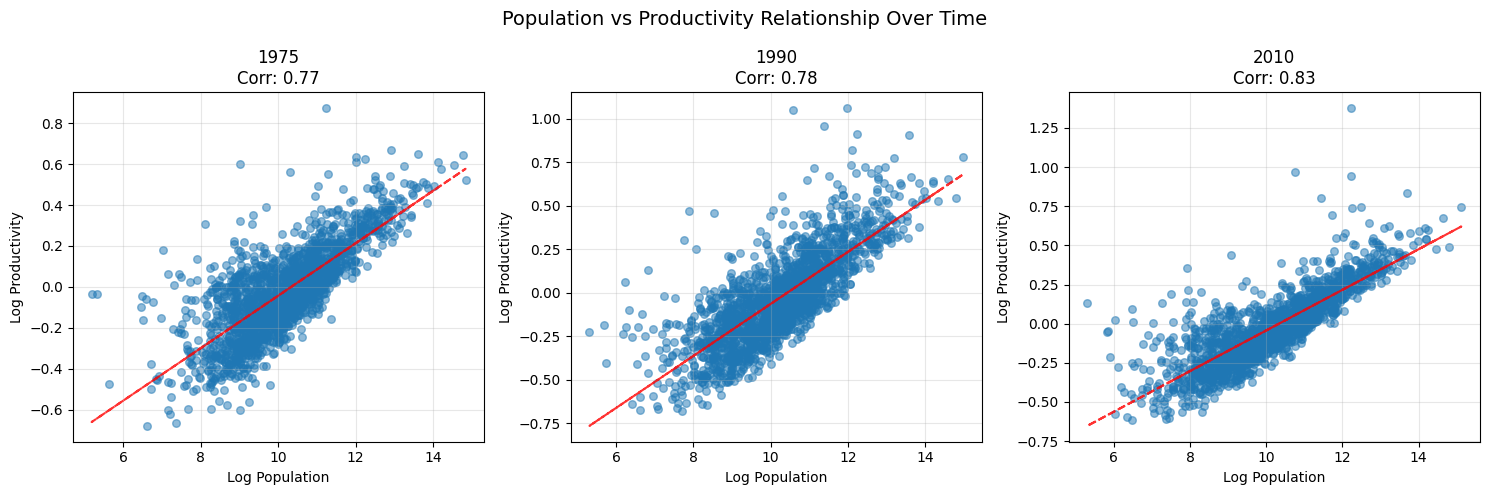

In [18]:
# Population vs Amenities Analysis
plt.figure(figsize=(15, 5))

# Choose three years for comparison
analysis_years = [1975, 1990, 2010]

for idx, year in enumerate(analysis_years, 1):
    plt.subplot(1, 3, idx)
    
    # Create scatter plot
    plt.scatter(
        np.log(final_gdf[f'Population_{year}']), 
        np.log(final_gdf[f'A_{year}']),
        alpha=0.5,
        s=30
    )
    
    # Add trend line
    z = np.polyfit(
        np.log(final_gdf[f'Population_{year}']), 
        np.log(final_gdf[f'A_{year}']), 
        1
    )
    p = np.poly1d(z)
    plt.plot(
        np.log(final_gdf[f'Population_{year}']),
        p(np.log(final_gdf[f'Population_{year}'])),
        "r--",
        alpha=0.8
    )
    
    # Calculate correlation
    corr = np.corrcoef(
        np.log(final_gdf[f'Population_{year}']),
        np.log(final_gdf[f'A_{year}'])
    )[0,1]
    
    plt.title(f'{year}\nCorr: {corr:.2f}', fontsize=12)
    plt.xlabel('Log Population', fontsize=10)
    plt.ylabel('Log Productivity', fontsize=10)
    plt.grid(True, alpha=0.3)

plt.suptitle('Population vs Productivity Relationship Over Time', fontsize=14)
plt.tight_layout()
plt.show()

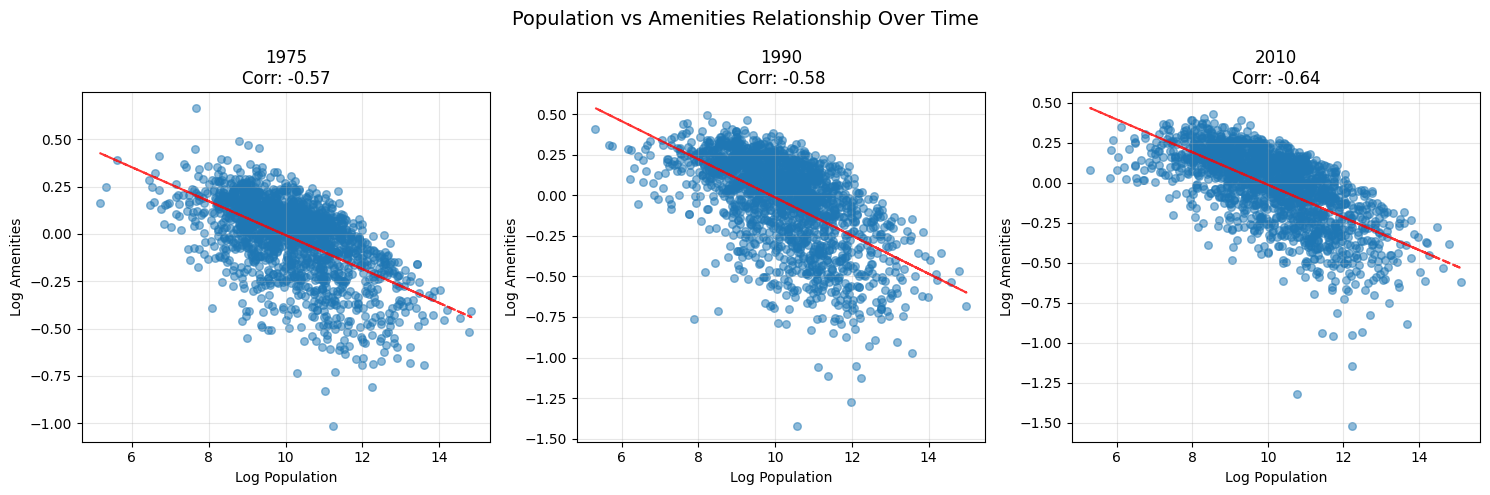

In [19]:
# Population vs Amenities Analysis
plt.figure(figsize=(15, 5))

# Choose three years for comparison
analysis_years = [1975, 1990, 2010]

for idx, year in enumerate(analysis_years, 1):
    plt.subplot(1, 3, idx)
    
    # Create scatter plot
    plt.scatter(
        np.log(final_gdf[f'Population_{year}']), 
        np.log(final_gdf[f'u_{year}']),
        alpha=0.5,
        s=30
    )
    
    # Add trend line
    z = np.polyfit(
        np.log(final_gdf[f'Population_{year}']), 
        np.log(final_gdf[f'u_{year}']), 
        1
    )
    p = np.poly1d(z)
    plt.plot(
        np.log(final_gdf[f'Population_{year}']),
        p(np.log(final_gdf[f'Population_{year}'])),
        "r--",
        alpha=0.8
    )
    
    # Calculate correlation
    corr = np.corrcoef(
        np.log(final_gdf[f'Population_{year}']),
        np.log(final_gdf[f'u_{year}'])
    )[0,1]
    
    plt.title(f'{year}\nCorr: {corr:.2f}', fontsize=12)
    plt.xlabel('Log Population', fontsize=10)
    plt.ylabel('Log Amenities', fontsize=10)
    plt.grid(True, alpha=0.3)

plt.suptitle('Population vs Amenities Relationship Over Time', fontsize=14)
plt.tight_layout()
plt.show()

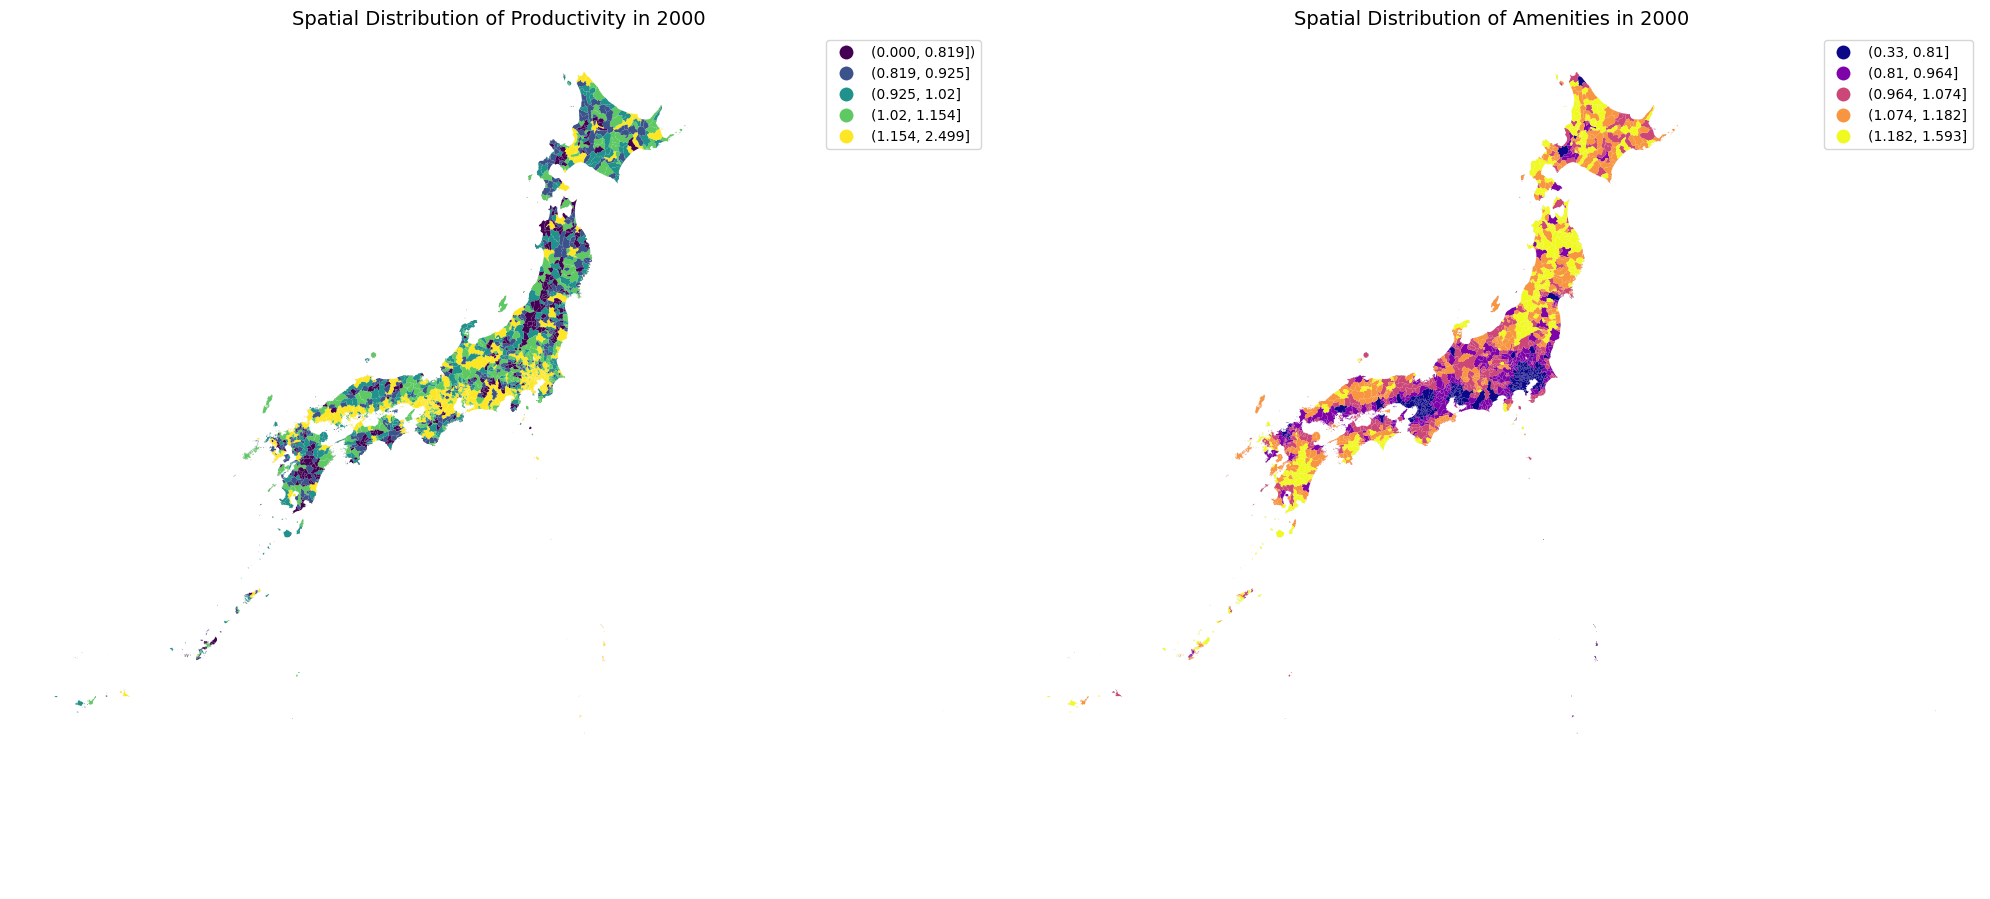

In [33]:
# Set up the figure
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Define number of quantiles
n_quantiles = 5

# Map 1: Productivity (A_2000) with quantiles
if 'A_2000' in final_gdf.columns:
    # Create a copy to avoid modifying the original
    plot_data = final_gdf.copy()
    
    # Ensure no negative values (floor at zero)
    plot_data['A_2000'] = plot_data['A_2000'].clip(lower=0)
    
    # Create quantile categories
    plot_data['A_2000_cat'] = pd.qcut(plot_data['A_2000'], q=n_quantiles, duplicates='drop')
    
    # Plot with the categorical column
    plot_data.plot(
        column='A_2000_cat',
        cmap='viridis',
        categorical=True,
        legend=True,
        ax=axes[0]
    )
    
    # Get the legend and adjust if needed
    legend = axes[0].get_legend()
    if legend:
        # Get the current labels
        texts = legend.get_texts()
        # Check if the first label contains a negative value
        if '-' in texts[0].get_text() and texts[0].get_text().split(',')[0].strip('(').strip() < '0':
            # Replace with a non-negative version
            current_text = texts[0].get_text()
            upper_bound = current_text.split(',')[1].strip().strip(')')
            texts[0].set_text(f'(0.000, {upper_bound})')
else:
    print("A_2000 column not found")

axes[0].set_title('Spatial Distribution of Productivity in 2000', fontsize=14)
axes[0].set_axis_off()

# Map 2: Amenities (u_2000) with quantiles
if 'u_2000' in final_gdf.columns:
    # Create a copy to avoid modifying the original
    plot_data = final_gdf.copy()
    
    # Ensure no negative values (floor at zero)
    plot_data['u_2000'] = plot_data['u_2000'].clip(lower=0)
    
    # Create quantile categories
    plot_data['u_2000_cat'] = pd.qcut(plot_data['u_2000'], q=n_quantiles, duplicates='drop')
    
    # Plot with the categorical column
    plot_data.plot(
        column='u_2000_cat',
        cmap='plasma',  # Different colormap for amenities
        categorical=True,
        legend=True,
        ax=axes[1]
    )
    
    # Get the legend and adjust if needed
    legend = axes[1].get_legend()
    if legend:
        # Get the current labels
        texts = legend.get_texts()
        # Check if the first label contains a negative value
        if '-' in texts[0].get_text() and texts[0].get_text().split(',')[0].strip('(').strip() < '0':
            # Replace with a non-negative version
            current_text = texts[0].get_text()
            upper_bound = current_text.split(',')[1].strip().strip(')')
            texts[0].set_text(f'(0.000, {upper_bound})')
else:
    print("u_2000 column not found")

axes[1].set_title('Spatial Distribution of Amenities in 2000', fontsize=14)
axes[1].set_axis_off()

plt.tight_layout()
plt.show()